In [111]:
import pandas as pd 
import numpy as np 
import re
import matplotlib.pyplot as plt

# Custom legend with separate elements
from matplotlib.lines import Line2D
from scipy.stats import pearsonr, spearmanr

In [2]:
raw_data = """
Model	Init Gen	Num Corr	init_ans_with_new	only_better_corr	train_from_init	Status	Train Acc	Test Acc	Train Corr Acc	Test Corr Acc
Phi3-mini-instruct-4k	1	1	1	1	1	done	
"0.306        0.302        0.308        0.29        0.312        0.298        0.312        0.314        0.3        0.31        0.308
0.304        0.312        0.308        0.32        0.298        0.306        0.31        0.304        0.31        0.304        0.308
0.36        0.358        0.364        0.344        0.352        0.342        0.35        0.356        0.35        0.356        0.372
0.344        0.37        0.366        0.37        0.356        0.372        0.36        0.354        0.338        0.358        0.358
32        34        33        34        27        29        28        28        31        28        37"			
Phi3-mini-instruct-4k	1	3	1	1	1	done	
"0.306	0.324	0.296	0.298	0.31	0.308	0.314	0.318	0.324	0.306	0.316
0.304	0.316	0.308	0.312	0.326	0.304	0.302	0.326	0.312	0.32	0.3
0.358	0.3633	0.3527	0.3493	0.348	0.3507	0.358	0.3607	0.3593	0.346	0.358
0.342	0.36	0.36	0.352	0.354	0.346	0.348	0.376	0.358	0.36	0.34
95	74	97	91	82	70	91	80	72	77	"			
Phi3-mini-instruct-4k	3	1	1	1	1	ready				
Phi3-mini-instruct-4k	3	3	1	1	1	done	
"0.3133	0.33	0.3313	0.326	0.3207	0.3207	0.3373	0.3213	0.328	0.3267	0.3207
0.334	0.326	0.32	0.306	0.342	0.308	0.322	0.328	0.324	0.312	0.324
0.3573	0.37	0.3702	0.3613	0.3629	0.3636	0.3671	0.3627	0.3711	0.366	0.3684
0.372	0.362	0.346	0.34	0.362	0.342	0.35	0.368	0.356	0.332	0.364
1011	988	963	979	1055	1115	975	1044	1038	1025	1158"			
Phi3-mini-instruct-4k	5	1	1	1	1	done	
"0.2988	0.328	0.3288	0.3332	0.3208	0.3264	0.3248	0.3292	0.3396	0.3256	0.3304
0.308	0.334	0.318	0.322	0.306	0.316	0.318	0.306	0.318	0.32	0.31
0.3432	0.3716	0.3792	0.3664	0.3492	0.3628	0.356	0.356	0.3752	0.3544	0.3544
0.378	0.378	0.35	0.352	0.32	0.336	0.356	0.35	0.352	0.348	0.344
1015	942	1090	991	985	980	892	869	931	977	950"			
Phi3-mini-instruct-4k	1	5	1	1	1	ready				
Phi3-mini-instruct-4k	5	3	1	1	1	ready				
Phi3-mini-instruct-4k	3	5	1	1	1	done	
"0.3073	0.3473	0.362	0.326	0.332	0.3247	0.3207	0.34	0.324	0.3447	0.332
0.314	0.33	0.33	0.316	0.324	0.326	0.318	0.312	0.332	0.326	0.324
0.3487	0.3795	0.3985	0.3568	0.3691	0.3669	0.3665	0.3767	0.3669	0.3764	0.3769
0.362	0.38	0.364	0.352	0.384	0.344	0.358	0.362	0.36	0.34	0.358
1767	1543	1577	1652	1740	1676	1918	1614	1734	1539	1833"			
Phi3-mini-instruct-4k	5	5	1	1	1	done	
"0.2988	0.3564	0.358	0.366	0.3604	0.3584	0.3616	0.3744	0.3796	0.3712	0.3644
0.308	0.324	0.322	0.314	0.312	0.322	0.336	0.316	0.338	0.35	0.334
0.3409	0.3934	0.3957	0.4016	0.4033	0.4066	0.4139	0.42	0.414	0.4127	0.4155
0.356	0.362	0.374	0.354	0.346	0.348	0.368	0.354	0.346	0.376	0.376
5017	4494	4997	4993	5166	5225	5431	5132	4709	5121	5377"
"""

In [3]:
# Re-parse the data with improved logic

# Split the data into lines
lines = raw_data.strip().split('\n')

# Extract header
header = lines[0].split('\t')

# Prepare for data parsing
data_rows = []
current_row = []
current_lists = []

for line in lines[1:]:
    # Check if the line starts a new model entry
    if line.startswith('Phi3-mini-instruct-4k'):
        if current_row:
            # Add any accumulated lists
            while len(current_lists) < 5:
                current_lists.append([])
            current_row += current_lists[:5]
            data_rows.append(current_row)
        # Start new row
        parts = line.split('\t')
        current_row = parts[:7]  # First 7 columns
        current_lists = []
        data_string = re.findall(r'"(.*?)"', line, re.DOTALL)
        if data_string:
            current_lists = [list(map(float, r.strip().split())) for r in data_string[0].split('\n')]
    else:
        # Continuation of data lists
        if '"' in line:
            line = line.replace('"', '')
        if line.strip():
            current_lists.append(list(map(float, line.strip().split())))

# Append the last row if exists
if current_row:
    while len(current_lists) < 5:
        current_lists.append([])
    current_row += current_lists[:5]
    data_rows.append(current_row)

# Ensure all rows have the correct number of columns
for row in data_rows:
    while len(row) < 12:
        row.append([])

# Create DataFrame
df_final = pd.DataFrame(data_rows, columns=header[:7] + [f'List_{i+1}' for i in range(5)])

df_final[['Init Gen', 'Num Corr']] = df_final[['Init Gen', 'Num Corr']].astype(int)

In [4]:
df_final.columns = ['Model', 'Init Gen', 'Num Corr', 'init_ans_with_new',
       'only_better_corr', 'train_from_init', 'Status', 'train', 'test',
       'ctrain', 'ctest', 'filter']

In [5]:
# Initialize lists to collect the data

def extract_data(path):

    train_acc = []
    test_acc = []
    train_corr_acc = []
    test_corr_acc = []
    filtered_corrections = []

    # Open the log file and read line by line
    with open(path, 'r') as file:
        for line in file:
            if "Initial Train Accuracy" in line:
                match = re.search(r'Initial Train Accuracy (\d+\.\d+)', line)
                if match:
                    train_acc.append(float(match.group(1)))

            elif "Initial Test Accuracy" in line:
                match = re.search(r'Initial Test Accuracy (\d+\.\d+)', line)
                if match:
                    test_acc.append(float(match.group(1)))

            elif "Correction at step" in line and "Train Accuracy" in line:
                match = re.search(r'Correction at step \d+ Train Accuracy (\d+\.\d+)', line)
                if match:
                    train_corr_acc.append(float(match.group(1)))

            elif "Correction at step" in line and "Test Accuracy" in line:
                match = re.search(r'Correction at step \d+ Test Accuracy (\d+\.\d+)', line)
                if match:
                    test_corr_acc.append(float(match.group(1)))

            elif "Filtered" in line:
                match = re.search(r'Filtered (\d+) Corrections', line)
                if match:
                    filtered_corrections.append(int(match.group(1)))

    # Display the extracted data
    extracted_data = {
        "train": train_acc,
        "test": test_acc,
        "ctrain": train_corr_acc,
        "ctest": test_corr_acc,
        "filter": filtered_corrections
    }
    
    return extracted_data



In [6]:
extracted_data = extract_data('/home/data/v.moskvoretskii/QAC/logs/Self_Correct_STaR_phi__5_3_T_T_T_8batch_1epoch.log')

columns = extracted_data.keys()
init_gen = 5
num_corr = 3

matching_rows = df_final[(df_final['Init Gen'] == init_gen) & (df_final['Num Corr'] == num_corr)]
for col in columns:
    df_final.at[matching_rows.index[0], col] = extracted_data[col]


In [7]:
extracted_data = extract_data('/home/data/v.moskvoretskii/QAC/logs/Self_Correct_STaR_phi_3_1_TTT.log')

columns = extracted_data.keys()
init_gen = 3
num_corr = 1

matching_rows = df_final[(df_final['Init Gen'] == init_gen) & (df_final['Num Corr'] == num_corr)]
for col in columns:
    df_final.at[matching_rows.index[0], col] = extracted_data[col]

In [8]:
extracted_data = extract_data('/home/data/v.moskvoretskii/QAC/logs/Self_Correct_STaR_phi__1_5_T_T_T_8batch_1epoch.log')

columns = extracted_data.keys()
init_gen = 1
num_corr = 5

matching_rows = df_final[(df_final['Init Gen'] == init_gen) & (df_final['Num Corr'] == num_corr)]
for col in columns:
    df_final.at[matching_rows.index[0], col] = extracted_data[col]

In [95]:
# df = df_final

# df["Std Initial Test Score"] = df["test"].apply(np.std)
# df["Std Correction Test Score"] = df["ctest"].apply(np.std)

# # df["Mean Initial Test Score"] = df["Gen, test"].apply(np.mean)
# # df["Mean Correction Test Score"] = df["Corr step test"].apply(np.mean)

# df["Max Test Initial Score"] = df["test"].apply(max)
# df["Max Test Correction Score"] = df["ctest"].apply(max)

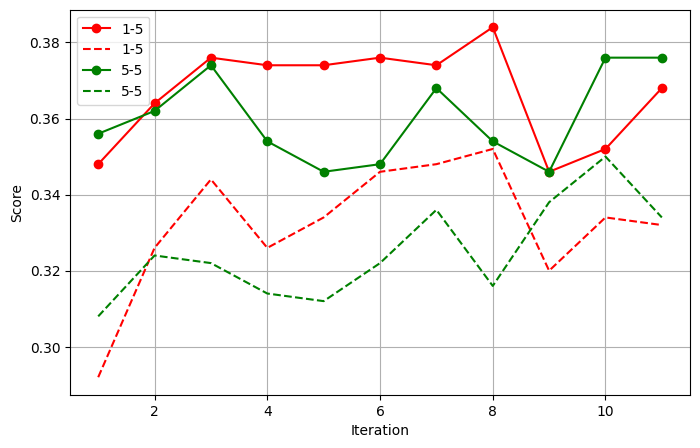

In [109]:
filtered_data = df[
    (df["Init Gen"] == 3) &
    (df["Num Corr"] == 5) 
]
ctest = filtered_data["ctest"].iloc[0] if not filtered_data.empty else []
gen_train = filtered_data["test"].iloc[0] if not filtered_data.empty else []

filtered_data2 = df[
    (df["Init Gen"] == 1) &
    (df["Num Corr"] == 5) 
]
ctest_2 = filtered_data2["ctest"].iloc[0] if not filtered_data.empty else []
gen_train_2 = filtered_data2["test"].iloc[0] if not filtered_data.empty else []

filtered_data3 = df[
    (df["Init Gen"] == 5) &
    (df["Num Corr"] == 5) 
]
ctest_3 = filtered_data3["ctest"].iloc[0] if not filtered_data.empty else []
gen_train_3 = filtered_data3["test"].iloc[0] if not filtered_data.empty else []


filtered_data4 = df[
    (df["Init Gen"] == 5) &
    (df["Num Corr"] == 1) 
]
ctest_4 = filtered_data4["ctest"].iloc[0] if not filtered_data.empty else []
gen_train_4 = filtered_data4["test"].iloc[0] if not filtered_data.empty else []

plt.figure(figsize=(8, 5))

# First setting (blue)
# plt.plot(range(1, len(ctest) + 1), ctest, marker='o', linestyle='-', color='b', label="3-5")
# plt.plot(range(1, len(gen_train) + 1), gen_train, marker='s', linestyle='--', color='b', label="3-5")

# Second setting (red)
plt.plot(range(1, len(ctest_2) + 1), ctest_2, marker='o', linestyle='-', color='r', label="1-5")
plt.plot(range(1, len(ctest_2) + 1), gen_train_2, linestyle='--', color='r', label="1-5")

# Second setting (red)
plt.plot(range(1, len(ctest_3) + 1), ctest_3, marker='o', linestyle='-', color='g', label="5-5")
plt.plot(range(1, len(ctest_3) + 1), gen_train_3, linestyle='--', color='g', label="5-5")

# plt.plot(range(1, len(ctest_4) + 1), ctest_4, marker='o', linestyle='-', color='g', label="5-1")
# plt.plot(range(1, len(ctest_4) + 1), gen_train_4, linestyle='--', color='g', label="5-1")


# plt.plot(range(1, len(ctest_4) + 1), ctest_4, marker='o', linestyle='-', color='y', label="STaR w\ Iterative FT")

# plt.plot(range(1, len(ctest_5) + 1), ctest_5, marker='o', linestyle='-', color='black', label="STaR w\o Exploration")

# Labels and title
plt.xlabel("Iteration")
plt.ylabel("Score")
#plt.title("STaR Versions Corrections Performance")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [9]:
path_ls = [
    '/home/data/v.moskvoretskii/QAC/logs/Self_Correct_STaR_phi_1_5_FFT.log',
    '/home/data/v.moskvoretskii/QAC/logs/Self_Correct_STaR_phi_1_5_FTT.log',
    '/home/data/v.moskvoretskii/QAC/logs/Self_Correct_STaR_phi_1_5_TFF.log',
    '/home/data/v.moskvoretskii/QAC/logs/Self_Correct_STaR_phi_1_5_FFT.log',
    '/home/data/v.moskvoretskii/QAC/logs/Self_Correct_STaR_phi_1_5_TTF.log',
    '/home/data/v.moskvoretskii/QAC/logs/Self_Correct_STaR_phi_1_5_TFT.log',

]

for path in path_ls:
    extracted_data = extract_data(path)

    columns = extracted_data.keys()
    init_gen = 1
    num_corr = 5
    model = 'Phi3-mini-instruct-4k'
    init_ans_with_new = path[-7] == 'T'
    only_better_corr = path[-6] == 'T'
    train_from_init = path[-5] == 'T'
    status = 'done'

    new_row = {}
    for col in columns:
        new_row[col] = [extracted_data[col]]

    new_row['Init Gen'] = init_gen
    new_row['Num Corr'] = num_corr
    new_row['Model'] = model
    new_row['Status'] = status
    new_row['init_ans_with_new'] = init_ans_with_new
    new_row['train_from_init'] = train_from_init
    new_row['only_better_corr'] = only_better_corr

    df_final = pd.concat([df_final, pd.DataFrame(new_row)])

In [10]:
new_row = """0.306	0.304	0.3576        0.3464        0.3568        0.3532        0.362        0.364        0.3668        0.368        0.3744        0.3756        0.3716	0.348        0.346        0.364        0.336        0.358        0.358        0.348        0.348        0.346        0.374        0.364	742        122        153        137        158        169        171        183        194        203        191"""

train, test, ctrain, ctest, filter = new_row.split('\t')

train = list(map(float, train.split('        ')))
test = list(map(float, test.split('        ')))
ctrain = list(map(float, ctrain.split('        ')))
ctest = list(map(float, ctest.split('        ')))
filter = list(map(int, filter.split('        ')))

init_gen = 1
num_corr = 5
model = 'Phi3-mini-instruct-4k'
init_ans_with_new = False
only_better_corr = False
train_from_init = False
status = 'done'

new_row = {}

new_row['train'] = [train]
new_row['test'] = [test]
new_row['ctrain'] = [ctrain]
new_row['ctest'] = [ctest]
new_row['filter'] = [filter]
new_row['Init Gen'] = init_gen
new_row['Num Corr'] = num_corr
new_row['Model'] = model
new_row['Status'] = status
new_row['init_ans_with_new'] = init_ans_with_new
new_row['train_from_init'] = train_from_init
new_row['only_better_corr'] = only_better_corr
df_final = pd.concat([df_final, pd.DataFrame(new_row)])

In [11]:
new_row = """0.306	0.304	0.3576        0.3568        0.3708        0.3656        0.368        0.3804        0.376        0.3836        0.38        0.3832        0.38	0.348        0.352        0.356        0.366        0.37        0.374        0.372        0.36        0.372        0.362        0.352	152        153        181        170        183        208        202        222        213        216        211"""

train, test, ctrain, ctest, filter = new_row.split('\t')

train = list(map(float, train.split('        ')))
test = list(map(float, test.split('        ')))
ctrain = list(map(float, ctrain.split('        ')))
ctest = list(map(float, ctest.split('        ')))
filter = list(map(int, filter.split('        ')))

init_gen = 1
num_corr = 5
model = 'Phi3-mini-instruct-4k'
init_ans_with_new = False
only_better_corr = True
train_from_init = False
status = 'done'

new_row = {}

new_row['train'] = [train]
new_row['test'] = [test]
new_row['ctrain'] = [ctrain]
new_row['ctest'] = [ctest]
new_row['filter'] = [filter]
new_row['Init Gen'] = init_gen
new_row['Num Corr'] = num_corr
new_row['Model'] = model
new_row['Status'] = status
new_row['init_ans_with_new'] = init_ans_with_new
new_row['train_from_init'] = train_from_init
new_row['only_better_corr'] = only_better_corr
df_final = pd.concat([df_final, pd.DataFrame(new_row)])

In [12]:
df_final[['train_from_init', 'only_better_corr', 'init_ans_with_new']] = df_final[['train_from_init', 'only_better_corr', 'init_ans_with_new']].astype(bool)

In [24]:
df = df_final[(df_final['Init Gen'] == 1) & (df_final['Num Corr'] == 5)]

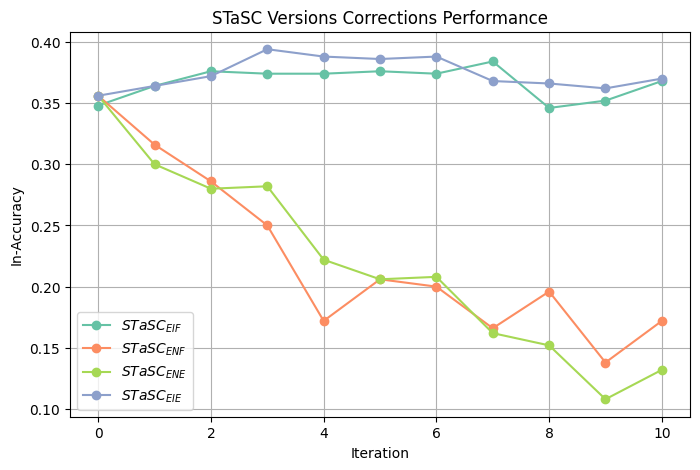

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use Seaborn's Set2 color palette
sns.set_palette("Set2")
colors = sns.color_palette("Set2")

# Filter the data for the given conditions
filtered_data = df[
    (df["init_ans_with_new"] == True) &
    (df["only_better_corr"] == True) &
    (df["train_from_init"] == True)
]

# Extract values
ctest = filtered_data["ctest"].iloc[0] if not filtered_data.empty else []
gen_train = filtered_data["test"].iloc[0] if not filtered_data.empty else []

# Filter the data for the given conditions
filtered_data_3 = df[
    (df["init_ans_with_new"] == True) &
    (df["only_better_corr"] == False) &
    (df["train_from_init"] == True)
]

# Extract values
ctest_3 = filtered_data_3["ctest"].iloc[0] if not filtered_data.empty else []
gen_train_3 = filtered_data_3["test"].iloc[0] if not filtered_data.empty else []

# Filter the data for the given conditions
filtered_data_4 = df[
    (df["init_ans_with_new"] == True) &
    (df["only_better_corr"] == True) &
    (df["train_from_init"] == False)
]

# Extract values
ctest_4 = filtered_data_4["ctest"].iloc[0] if not filtered_data.empty else []
gen_train_4 = filtered_data_4["test"].iloc[0] if not filtered_data.empty else []

# Filter the data for the given conditions
filtered_data_5 = df[
    (df["init_ans_with_new"] == False) &
    (df["only_better_corr"] == True) &
    (df["train_from_init"] == True)
]

# Extract values
ctest_5 = filtered_data_5["ctest"].iloc[0] if not filtered_data.empty else []
gen_train_5 = filtered_data_5["test"].iloc[0] if not filtered_data.empty else []


# Filter the data for the given conditions
filtered_data_6 = df[
    (df["init_ans_with_new"] == True) &
    (df["only_better_corr"] == False) &
    (df["train_from_init"] == False)
]

# Extract values
ctest_6 = filtered_data_6["ctest"].iloc[0] if not filtered_data.empty else []
gen_train_6 = filtered_data_6["test"].iloc[0] if not filtered_data.empty else []

plt.figure(figsize=(8, 5))

plt.plot(range(len(ctest)), ctest, marker='o', linestyle='-', color=colors[0], label=r"$STaSC_{EIF}$")
plt.plot(range(len(ctest)), ctest_3, marker='o', linestyle='-', color=colors[1], label=r"$STaSC_{ENF}$")
plt.plot(range(len(ctest)), ctest_6, marker='o', linestyle='-', color=colors[4], label=r"$STaSC_{ENE}$")
plt.plot(range(len(ctest)), ctest_4, marker='o', linestyle='-', color=colors[2], label=r"$STaSC_{EIE}$")
#plt.plot(range(len(ctest)), ctest_5, marker='o', linestyle='-', color=colors[3], label=r"$STaSC_{FIF}$")


# Labels and title
plt.xlabel("Iteration")
plt.ylabel("In-Accuracy")
plt.title("STaSC Versions Corrections Performance")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


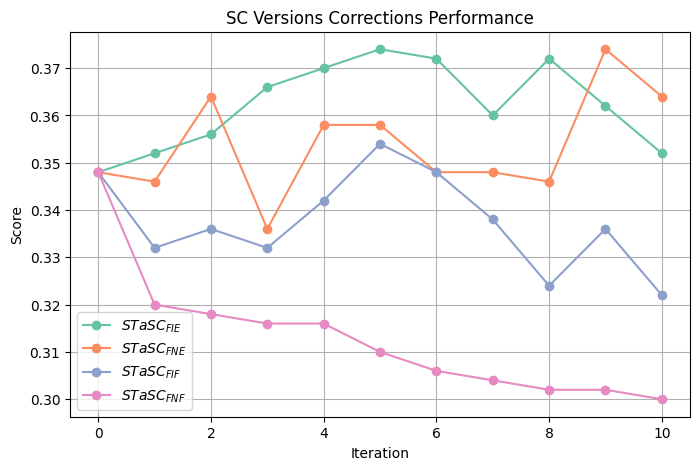

In [22]:
import matplotlib.pyplot as plt

# Filter the data for the given conditions
filtered_data = df[
    (df["init_ans_with_new"] == True) &
    (df["only_better_corr"] == True) &
    (df["train_from_init"] == True)
]

# Extract values
ctest = filtered_data["ctest"].iloc[0] if not filtered_data.empty else []
gen_train = filtered_data["test"].iloc[0] if not filtered_data.empty else []

filtered_data_2 = df[
    (df["init_ans_with_new"] == False) &
    (df["only_better_corr"] == True) &
    (df["train_from_init"] == False)
]

# Extract values for the second setting
ctest_2 = filtered_data_2["ctest"].iloc[0] if not filtered_data_2.empty else []
gen_train_2 = filtered_data_2["test"].iloc[0] if not filtered_data_2.empty else []

# Filter the data for the given conditions
filtered_data_3 = df[
    (df["init_ans_with_new"] == False) &
    (df["only_better_corr"] == False) &
    (df["train_from_init"] == False)
]

# Extract values
ctest_3 = filtered_data_3["ctest"].iloc[0] if not filtered_data.empty else []
gen_train_3 = filtered_data_3["test"].iloc[0] if not filtered_data.empty else []

# Filter the data for the given conditions
filtered_data_4 = df[
    (df["init_ans_with_new"] == False) &
    (df["only_better_corr"] == True) &
    (df["train_from_init"] == True)
]

# Extract values
ctest_4 = filtered_data_4["ctest"].iloc[0] if not filtered_data.empty else []
gen_train_4 = filtered_data_4["test"].iloc[0] if not filtered_data.empty else []

filtered_data_5 = df[
    (df["init_ans_with_new"] == False) &
    (df["only_better_corr"] == False) &
    (df["train_from_init"] == True)
]

# Extract values for the second setting
ctest_5 = filtered_data_5["ctest"].iloc[0] if not filtered_data_2.empty else []
gen_train_5 = filtered_data_5["test"].iloc[0] if not filtered_data_2.empty else []

# Plot the lines
# Plot the lines for both settings
plt.figure(figsize=(8, 5))

plt.plot(range(len(ctest)), ctest_2, marker='o', linestyle='-', color=colors[0], label=r"$STaSC_{FIE}$")
plt.plot(range(len(ctest)), ctest_3, marker='o', linestyle='-', color=colors[1], label=r"$STaSC_{FNE}$")
plt.plot(range(len(ctest)), ctest_4, marker='o', linestyle='-', color=colors[2], label=r"$STaSC_{FIF}$")
plt.plot(range(len(ctest)), ctest_5, marker='o', linestyle='-', color=colors[3], label=r"$STaSC_{FNF}$")


# Labels and title
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("SC Versions Corrections Performance")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


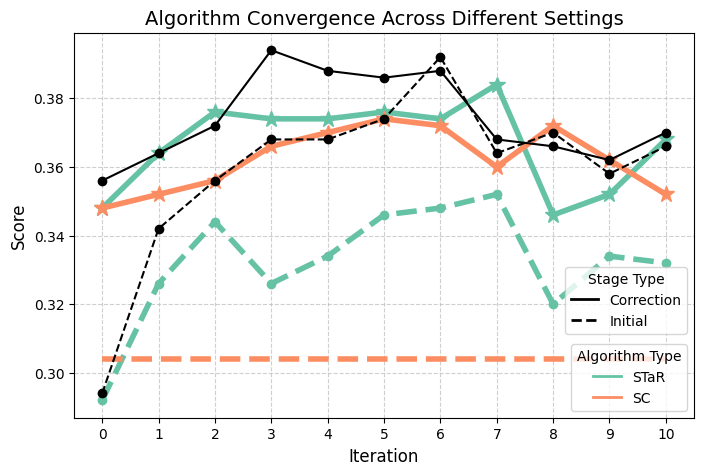

In [35]:
import seaborn as sns

# Use Seaborn's Set2 color palette
sns.set_palette("Set2")
colors = sns.color_palette("Set2")

# Filter the data for the given conditions
filtered_data = df[
    (df["init_ans_with_new"] == True) &
    (df["only_better_corr"] == True) &
    (df["train_from_init"] == True)
]

# Extract values
ctest = filtered_data["ctest"].iloc[0] if not filtered_data.empty else []
gen_train = filtered_data["test"].iloc[0] if not filtered_data.empty else []

filtered_data_2 = df[
    (df["init_ans_with_new"] == False) &
    (df["only_better_corr"] == True) &
    (df["train_from_init"] == False)
]

# Extract values for the second setting
ctest_2 = filtered_data_2["ctest"].iloc[0] if not filtered_data_2.empty else []
gen_train_2 = filtered_data_2["test"].iloc[0] if not filtered_data_2.empty else []





# Create the plot with improved aesthetics
plt.figure(figsize=(8, 5))

# First setting (STaR)
plt.plot(range(0, len(ctest)), ctest, marker='*', markersize=12, linestyle='-', linewidth=4, color=colors[0], label="Correction (STaR)")
plt.plot(range(0, len(ctest)), gen_train, marker='.', markersize=12, linestyle='--', linewidth=4, color=colors[0], label="Initial (STaR)")

# Second setting (SC)
plt.plot(range(0, len(ctest)), ctest_2, marker='*', markersize=12, linestyle='-', linewidth=4, color=colors[1], label="Correction (SC)")
plt.plot(range(0, len(ctest)), [gen_train_2[0]] * len(ctest), linestyle='--', linewidth=4, color=colors[1], label="Initial (SC)")

plt.plot(range(0, len(ctest_5)), gen_train_5, marker='o', linestyle='--', color='black', label="SC w\ Exploration")
plt.plot(range(0, len(ctest_5)), ctest_5, marker='o', linestyle='-', color='black', label="SC w\ Exploration")


# Labels and title
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Algorithm Convergence Across Different Settings", fontsize=14)

# Ensure x-axis starts from 0 and shows all iterations
plt.xticks(range(0, max(len(ctest), len(ctest_2))), fontsize=10)
plt.yticks(fontsize=10)

# Custom legend with separate elements
from matplotlib.lines import Line2D

# Create two legends placed closer together in the lower right corner
color_legend = plt.legend(
    handles=[
        Line2D([0], [0], color=colors[0], lw=2, label="STaR"),
        Line2D([0], [0], color=colors[1], lw=2, label="SC")
    ], loc='lower right', title="Algorithm Type", fontsize=10)

style_legend = plt.legend(
    handles=[
        Line2D([0], [0], color='black', lw=2, linestyle='-', label="Correction"),
        Line2D([0], [0], color='black', lw=2, linestyle='--', label="Initial")
    ], loc='lower right', bbox_to_anchor=(1, 0.2), title="Stage Type", fontsize=10)

# Add the first legend back to the plot
plt.gca().add_artist(color_legend)

plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


In [36]:
df_final.head()

,Model,Init Gen,Num Corr,init_ans_with_new,only_better_corr,train_from_init,Status,train,test,ctrain,ctest,filter
0,Phi3-mini-instruct-4k,1,1,True,True,True,done,"[0.306, 0.302, 0.308, 0.29, 0.312, 0.298, 0.31...","[0.304, 0.312, 0.308, 0.32, 0.298, 0.306, 0.31...","[0.36, 0.358, 0.364, 0.344, 0.352, 0.342, 0.35...","[0.344, 0.37, 0.366, 0.37, 0.356, 0.372, 0.36,...","[32.0, 34.0, 33.0, 34.0, 27.0, 29.0, 28.0, 28...."
1,Phi3-mini-instruct-4k,1,3,True,True,True,done,"[0.306, 0.324, 0.296, 0.298, 0.31, 0.308, 0.31...","[0.304, 0.316, 0.308, 0.312, 0.326, 0.304, 0.3...","[0.358, 0.3633, 0.3527, 0.3493, 0.348, 0.3507,...","[0.342, 0.36, 0.36, 0.352, 0.354, 0.346, 0.348...","[95.0, 74.0, 97.0, 91.0, 82.0, 70.0, 91.0, 80...."
2,Phi3-mini-instruct-4k,3,1,True,True,True,ready,"[0.30466666666666664, 0.35533333333333333, 0.3...","[0.304, 0.334, 0.314, 0.316, 0.304, 0.312, 0.2...","[0.356, 0.37866666666666665, 0.364, 0.394, 0.3...","[0.356, 0.362, 0.352, 0.362, 0.348, 0.336, 0.3...","[373, 229, 318, 269, 340, 233, 397, 229, 188, ..."
3,Phi3-mini-instruct-4k,3,3,True,True,True,done,"[0.3133, 0.33, 0.3313, 0.326, 0.3207, 0.3207, ...","[0.334, 0.326, 0.32, 0.306, 0.342, 0.308, 0.32...","[0.3573, 0.37, 0.3702, 0.3613, 0.3629, 0.3636,...","[0.372, 0.362, 0.346, 0.34, 0.362, 0.342, 0.35...","[1011.0, 988.0, 963.0, 979.0, 1055.0, 1115.0, ..."
4,Phi3-mini-instruct-4k,5,1,True,True,True,done,"[0.2988, 0.328, 0.3288, 0.3332, 0.3208, 0.3264...","[0.308, 0.334, 0.318, 0.322, 0.306, 0.316, 0.3...","[0.3432, 0.3716, 0.3792, 0.3664, 0.3492, 0.362...","[0.378, 0.378, 0.35, 0.352, 0.32, 0.336, 0.356...","[1015.0, 942.0, 1090.0, 991.0, 985.0, 980.0, 8..."


In [37]:
df = df_final[(df_final['train_from_init'] == False)]

In [38]:
df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
df['filter'] = df['filter'].apply(np.array)

# filters = np.vstack(df['filter'].drop(1).apply(lambda x: x[:-1]).values).flatten()
# deltas = np.vstack(df['ctest_delta'].drop(1).values).flatten()
filters = np.vstack(df['filter'].apply(lambda x: x[:-1]).values).flatten()
deltas = np.vstack(df['ctest_delta'].values).flatten()
pearsonr(filters, deltas), spearmanr(filters, deltas)

/tmp/ipykernel_915979/3530555704.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
/tmp/ipykernel_915979/3530555704.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filter'] = df['filter'].apply(np.array)


-0.5110023207616552


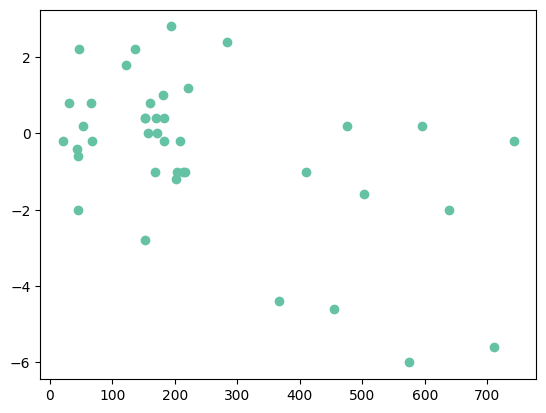

In [43]:
mask = filters < 2000
plt.scatter(filters[mask], deltas[mask])
print(np.corrcoef(filters[mask], deltas[mask])[0][1])

In [51]:
df["Std Initial Test Score"] = df["test"].apply(np.std)
df["Std Correction Test Score"] = df["ctest"].apply(np.std)

# df["Mean Initial Test Score"] = df["Gen, test"].apply(np.mean)
# df["Mean Correction Test Score"] = df["Corr step test"].apply(np.mean)

df["Max Test Initial Score"] = df["test"].apply(max)
df["Max Test Correction Score"] = df["ctest"].apply(max)

/tmp/ipykernel_915979/3736990569.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Std Initial Test Score"] = df["test"].apply(np.std)
/tmp/ipykernel_915979/3736990569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Std Correction Test Score"] = df["ctest"].apply(np.std)
/tmp/ipykernel_915979/3736990569.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [60]:
filtered_data = df[
    (df["init_ans_with_new"] == True) &
    (df["only_better_corr"] == False) &
    (df["train_from_init"] == False)
]
filtered_data

,Model,Init Gen,Num Corr,init_ans_with_new,only_better_corr,train_from_init,Status,train,test,ctrain,ctest,filter,Std Initial Test Score,Std Correction Test Score,Max Test Initial Score,Max Test Correction Score
0,Phi3-mini-instruct-4k,1,5,True,False,False,done,"[0.294, 0.26, 0.24, 0.23, 0.206, 0.192, 0.182,...","[0.294, 0.292, 0.274, 0.284, 0.224, 0.21, 0.21...","[0.3488, 0.2648, 0.244, 0.2304, 0.2028, 0.1908...","[0.356, 0.3, 0.28, 0.282, 0.222, 0.206, 0.208,...","[711, 639, 596, 574, 503, 476, 455, 410, 367, ...",0.062424,0.074435,0.294,0.356


In [28]:
data = """
+
5
5
10
+
-
0.2232	0.2924	0.3184	0.3428	0.3584	0.3716	0.3768	0.3808	0.3808	0.3852	0.3876
0.212	0.236	0.208	0.216	0.208	0.212	0.216	0.222	0.224	0.23	0.214
0.1575	0.2785	0.3147	0.342	0.355	0.374	0.381	0.3837	0.3834	0.3885	0.392
0.138	0.228	0.216	0.212	0.212	0.208	0.212	0.226	0.222	0.23	0.216
1608	1474	1534	1112	968	1052	995	924	1041	1197	1029
+
5
5
10
-
+
0.2232	0.2364	0.2456	0.2464	0.2484	0.244	0.252	0.2532	0.2624	0.2584	0.2532
0.212	0.216	0.23	0.232	0.234	0.228	0.24	0.238	0.218	0.238	0.236
0.1575	0.2261	0.2402	0.2391	0.2453	0.2362	0.2414	0.2485	0.2532	0.2478	0.2444
0.138	0.208	0.202	0.218	0.218	0.2	0.22	0.222	0.212	0.222	0.21
8237	12789	13427	13202	13707	13153	13195	13776	14278	13822	13532
+
5
5
10
-
-
0.2232	0.2336	0.2452	0.258	0.2652	0.268	0.2812	0.278	0.2896	0.2904	0.2932
0.212	0.224	0.234	0.208	0.23	0.212	0.232	0.196	0.208	0.222	0.194
0.1575	0.2254	0.245	0.2604	0.2694	0.2744	0.2854	0.285	0.2953	0.2932	0.2973
0.138	0.212	0.228	0.204	0.218	0.21	0.212	0.192	0.2	0.208	0.194
8237	12522	13768	14940	15341	15665	16664	16251	17082	17249	17386
-
5
5
10
+
+
0.2232
0.212
0.1623	0.2128	0.2242	0.2401	0.2584	0.2544	0.2558	0.2502	0.2534	0.2534	0.27
0.154	0.198	0.196	0.198	0.208	0.202	0.192	0.202	0.192	0.198	0.206
1695	2579	2975	3569	4353	4286	4420	4205	4350	4517	5108
-
5
5
10
+
-
0.2232
0.212
0.1623	0.214	0.23	0.2459	0.2646	0.2712	0.2816	0.2951	0.3018	0.3111
0.154	0.192	0.198	0.204	0.202	0.21	0.206	0.212	0.212	0.204
1695	2612	3166	3782	4705	4991	5496	6111	6491	6948
-
5
5
10
-
+
0.2232
0.212
0.1623	0.1974	0.2098	0.2101	0.2118	0.2136	0.2138	0.215	0.2166	0.2214	0.2216
0.154	0.194	0.196	0.198	0.192	0.194	0.188	0.198	0.196	0.196	0.196
8450	10375	10916	10964	11011	11067	11065	11086	11183	11315	11324
-
5
5
10
-
-
0.2232
0.212
0.1623	0.1976	0.2104	0.2176	0.2279	0.2346	0.2383	0.241	0.2403	0.2419	0.2461
0.154	0.194	0.192	0.198	0.202	0.202	0.198	0.202	0.198	0.2	0.206
8450	10364	10907	11256	11583	11846	11949	12015	12030	12074	12189
+
5
5
10
+
+
0.2212	0.268	0.2808	0.2696	0.274	0.28	0.292	0.296	0.2968	0.2828	0.2904
0.218	0.206	0.216	0.234	0.222	0.222	0.244	0.212	0.212	0.236	0.23
0.1483	0.2202	0.2656	0.2667	0.2837	0.2899	0.2944	0.3004	0.2973	0.2917	0.2957
0.164	0.168	0.19	0.224	0.224	0.224	0.232	0.214	0.206	0.228	0.218
1770	1505	1781	1814	2453	2562	2598	2667	2708	2938	2744
"""


# Re-parsing the data according to the required structure
lines = data.strip().split("\n")

# Container for structured data
structured_data = []

# Iterating through the lines while ensuring structured parsing
i = 0
while i < len(lines):
    if lines[i] in {"+", "-"}:  # Initial answer sign
        init_ans_with_new = lines[i]
        i += 1
        init_gen = int(lines[i])  # Initial gen integer
        i += 1
        num_corr = int(lines[i])  # Number of corrections integer
        i += 1
        iterations = int(lines[i])  # Iterations integer
        i += 1

        if lines[i] in {"+", "-"}:
            only_better_correction = lines[i]  # Only better correction sign
            i += 1
        else:
            only_better_correction = None

        if lines[i] in {"+", "-"}:
            train_from_initial = lines[i]  # Train from initial sign
            i += 1
        else:
            train_from_initial = None

        # Extracting numeric values
        values = []
        while i < len(lines) and any(c.isdigit() for c in lines[i]):
            values.append(list(map(float, lines[i].split())))
            i += 1

        # Ensuring exactly 5 lists (10 values each)
        while len(values) < 5:
            values.append([None] * 10)

        # Flattening values for DataFrame insertion
        row = [
            init_ans_with_new, init_gen, num_corr, iterations, only_better_correction, train_from_initial
        ] + values

        structured_data.append(row)
    else:
        i += 1

# Creating DataFrame with the correct column structure
columns = [
    "init_ans_with_new", "init_gen", "num_corr", "iterations",
    "only_better_corr", "train_from_init",
    "train", "test", "ctrain", "ctest", "filtered"
]

df_qwen = pd.DataFrame(structured_data, columns=columns)

df_qwen["init_ans_with_new"] = df_qwen["init_ans_with_new"].map({"+": True, "-": False})
df_qwen["only_better_corr"] = df_qwen["only_better_corr"].map({"+": True, "-": False, None: None})
df_qwen["train_from_init"] = df_qwen["train_from_init"].map({"+": True, "-": False, None: None})


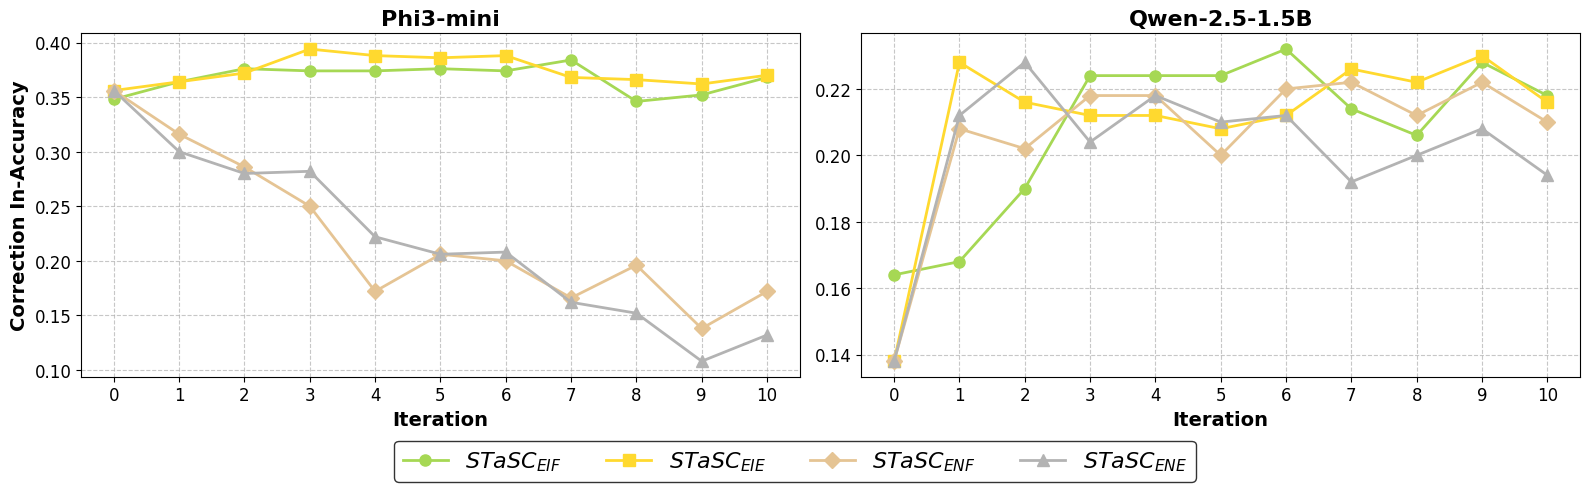

In [63]:
# Use Seaborn's Set2 color palette
sns.set_palette("Set2")
colors = sns.color_palette("Set2")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Function to filter and extract values
def get_values(df_temp, o1, o2, o3):
    filtered_data = df_temp[
        (df_temp["init_ans_with_new"] == o1) &
        (df_temp["only_better_corr"] == o2) &
        (df_temp["train_from_init"] == o3)
    ]
    ctest = filtered_data["ctest"].iloc[0] if not filtered_data.empty else []
    return ctest

# Extract values for df
df_ctest = get_values(df, True, True, True)
df_ctest_3 = get_values(df, True, False, True)
df_ctest_4 = get_values(df, True, True, False)
df_ctest_6 = get_values(df, True, False, False)

# Extract values for df_qwen
df_qwen_ctest = get_values(df_qwen, True, True, True)
df_qwen_ctest_3 = get_values(df_qwen, True, False, True)
df_qwen_ctest_4 = get_values(df_qwen, True, True, False)
df_qwen_ctest_6 = get_values(df_qwen, True, False, False)

# Plot for df
# Function to improve plot aesthetics
def style_axes(ax, title):
    ax.set_xlabel("Iteration", fontsize=14, fontweight='bold')
    ax.set_xticks(list(range(11)))
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', labelsize=12)

# Plot for df (Phi3-mini)
axes[0].plot(range(len(df_ctest)), df_ctest, marker='o', linestyle='-', color=colors[0], label=r"$STaSC_{EIF}$", markersize=8, linewidth=2)
axes[0].plot(range(len(df_ctest)), df_ctest_4, marker='s', linestyle='-', color=colors[2], label=r"$STaSC_{EIE}$", markersize=8, linewidth=2)
axes[0].plot(range(len(df_ctest)), df_ctest_3, marker='D', linestyle='-', color=colors[1], label=r"$STaSC_{ENF}$", markersize=8, linewidth=2)
axes[0].plot(range(len(df_ctest)), df_ctest_6, marker='^', linestyle='-', color=colors[3], label=r"$STaSC_{ENE}$", markersize=8, linewidth=2)
axes[0].set_ylabel("Correction In-Accuracy", fontsize=14, fontweight='bold')
style_axes(axes[0], "Phi3-mini")

# Plot for df_qwen (Qwen-2.5-1.5B)
axes[1].plot(range(len(df_qwen_ctest)), df_qwen_ctest, marker='o', linestyle='-', color=colors[0], label=r"$STaSC_{EIF}$", markersize=8, linewidth=2)
axes[1].plot(range(len(df_qwen_ctest)), df_qwen_ctest_4, marker='s', linestyle='-', color=colors[2], label=r"$STaSC_{EIE}$", markersize=8, linewidth=2)
axes[1].plot(range(len(df_qwen_ctest)), df_qwen_ctest_3, marker='D', linestyle='-', color=colors[1], label=r"$STaSC_{ENF}$", markersize=8, linewidth=2)
axes[1].plot(range(len(df_qwen_ctest)), df_qwen_ctest_6, marker='^', linestyle='-', color=colors[3], label=r"$STaSC_{ENE}$", markersize=8, linewidth=2)
style_axes(axes[1], "Qwen-2.5-1.5B")

# Create a shared legend below the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, frameon=True, fontsize=16, edgecolor='black', fancybox=True, borderpad=0.4)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig('stasc_e.pdf', dpi=3000, bbox_inches='tight')
plt.show()


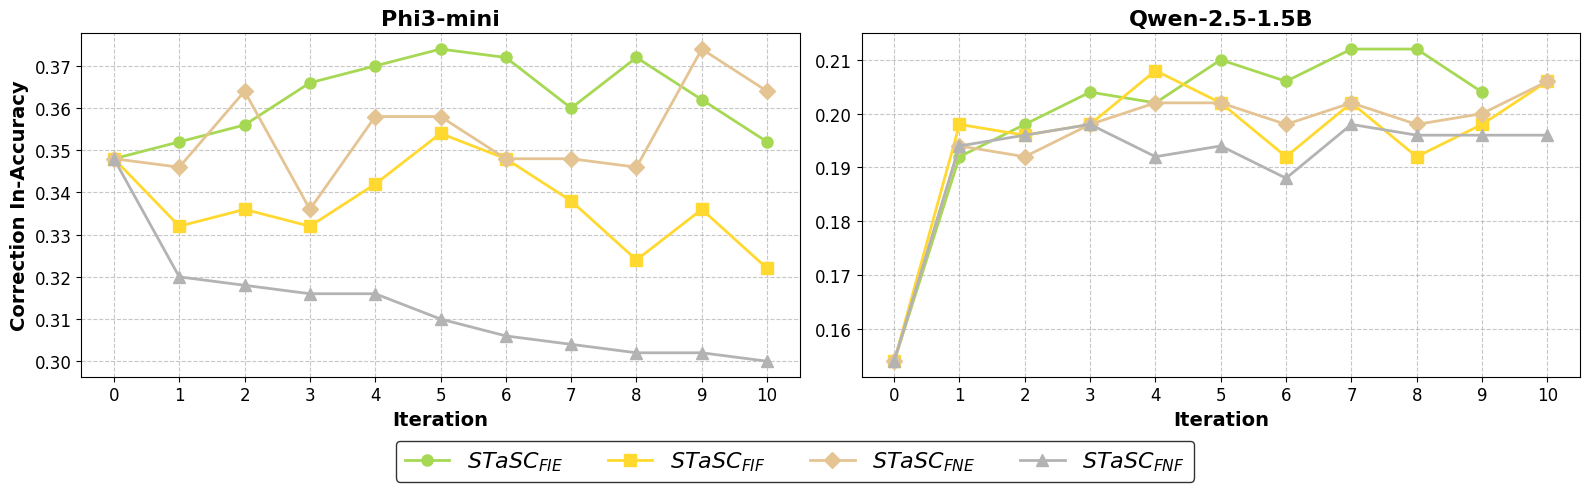

In [67]:
# Use Seaborn's Set2 color palette
sns.set_palette("Set2")
colors = sns.color_palette("Set2")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Function to filter and extract values
def get_values(df_temp, o1, o2, o3):
    filtered_data = df_temp[
        (df_temp["init_ans_with_new"] == o1) &
        (df_temp["only_better_corr"] == o2) &
        (df_temp["train_from_init"] == o3)
    ]
    ctest = filtered_data["ctest"].iloc[0] if not filtered_data.empty else []
    return ctest


# plt.plot(range(len(ctest)), ctest_2, marker='o', linestyle='-', color=colors[0], label=r"$STaSC_{FIE}$")
# plt.plot(range(len(ctest)), ctest_3, marker='o', linestyle='-', color=colors[1], label=r"$STaSC_{FNE}$")
# plt.plot(range(len(ctest)), ctest_4, marker='o', linestyle='-', color=colors[2], label=r"$STaSC_{FIF}$")
# plt.plot(range(len(ctest)), ctest_5, marker='o', linestyle='-', color=colors[3], label=r"$STaSC_{FNF}$")

# Extract values for df
df_ctest = get_values(df, False, True, False)
df_ctest_3 = get_values(df, False, False, False)
df_ctest_4 = get_values(df, False, True, True)
df_ctest_6 = get_values(df, False, False, True)

# Extract values for df_qwen
df_qwen_ctest = get_values(df_qwen, False, True, False)
df_qwen_ctest_3 = get_values(df_qwen, False, False, False)
df_qwen_ctest_4 = get_values(df_qwen, False, True, True)
df_qwen_ctest_6 = get_values(df_qwen, False, False, True)

# Plot for df
# Function to improve plot aesthetics
def style_axes(ax, title):
    ax.set_xlabel("Iteration", fontsize=14, fontweight='bold')
    ax.set_xticks(list(range(11)))
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', labelsize=12)

# Plot for df (Phi3-mini)
axes[0].plot(range(len(df_ctest)), df_ctest, marker='o', linestyle='-', color=colors[4], label=r"$STaSC_{FIE}$", markersize=8, linewidth=2)
axes[0].plot(range(len(df_ctest)), df_ctest_4, marker='s', linestyle='-', color=colors[5], label=r"$STaSC_{FIF}$", markersize=8, linewidth=2)
axes[0].plot(range(len(df_ctest)), df_ctest_3, marker='D', linestyle='-', color=colors[6], label=r"$STaSC_{FNE}$", markersize=8, linewidth=2)
axes[0].plot(range(len(df_ctest)), df_ctest_6, marker='^', linestyle='-', color=colors[7], label=r"$STaSC_{FNF}$", markersize=8, linewidth=2)
axes[0].set_ylabel("Correction In-Accuracy", fontsize=14, fontweight='bold')
style_axes(axes[0], "Phi3-mini")

# Plot for df_qwen (Qwen-2.5-1.5B)
axes[1].plot(range(len(df_qwen_ctest)), df_qwen_ctest, marker='o', linestyle='-', color=colors[4], label=r"$STaSC_{FIE}$", markersize=8, linewidth=2)
axes[1].plot(range(len(df_qwen_ctest_4)), df_qwen_ctest_4, marker='s', linestyle='-', color=colors[5], label=r"$STaSC_{FIF}$", markersize=8, linewidth=2)
axes[1].plot(range(len(df_qwen_ctest_3)), df_qwen_ctest_3, marker='D', linestyle='-', color=colors[6], label=r"$STaSC_{FNE}$", markersize=8, linewidth=2)
axes[1].plot(range(len(df_qwen_ctest_6)), df_qwen_ctest_6, marker='^', linestyle='-', color=colors[7], label=r"$STaSC_{FNF}$", markersize=8, linewidth=2)
style_axes(axes[1], "Qwen-2.5-1.5B")

# Create a shared legend below the plots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, frameon=True, fontsize=16, edgecolor='black', fancybox=True, borderpad=0.4)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig('stasc_f.pdf', dpi=3000, bbox_inches='tight')
plt.show()


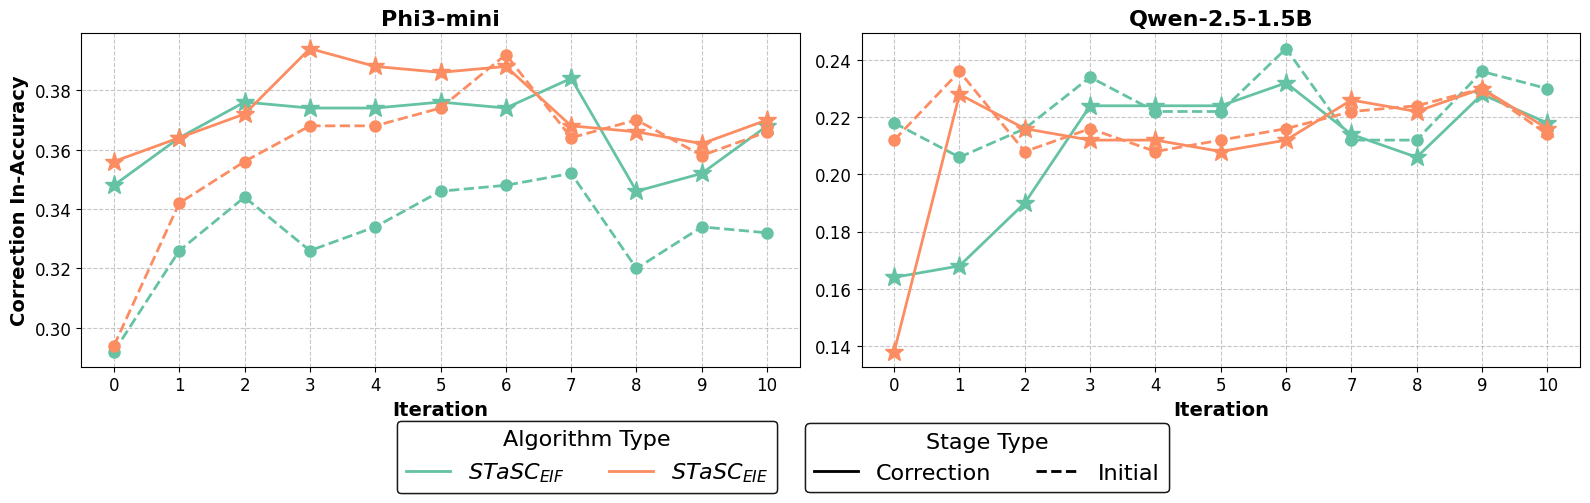

In [110]:
# Use Seaborn's Set2 color palette
sns.set_palette("Set2")
colors = sns.color_palette("Set2")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Function to filter and extract values
def get_values(df_temp, o1, o2, o3):
    filtered_data = df_temp[
        (df_temp["init_ans_with_new"] == o1) &
        (df_temp["only_better_corr"] == o2) &
        (df_temp["train_from_init"] == o3)
    ]
    ctest = filtered_data["ctest"].iloc[0] if not filtered_data.empty else []
    test = filtered_data["test"].iloc[0] if not filtered_data.empty else []

    return test, ctest

# Extract values for df
phi_star, phi_star_c = get_values(df, True, True, True)
phi_star_e, phi_star_ec = get_values(df, True, True, False)


# Extract values for df_qwen
qwew_star, qwew_star_c = get_values(df_qwen, True, True, True)
qwen_star_e, qwen_star_ec = get_values(df_qwen, True, True, False)


# Plot for df
# Function to improve plot aesthetics
def style_axes(ax, title):
    ax.set_xlabel("Iteration", fontsize=14, fontweight='bold')
    ax.set_xticks(list(range(11)))
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', labelsize=12)

# Plot for df (Phi3-mini)
axes[0].plot(range(len(phi_star)), phi_star, marker='o', linestyle='--', color=colors[0], label=r"$STaSC_{FIE}$", markersize=8, linewidth=2)
axes[0].plot(range(len(phi_star_c)), phi_star_c, marker='*', linestyle='-', color=colors[0], label=r"$STaSC_{FIF}$", markersize=14, linewidth=2)
axes[0].plot(range(len(phi_star_e)), phi_star_e, marker='o', linestyle='--', color=colors[1], label=r"$STaSC_{FNE}$", markersize=8, linewidth=2)
axes[0].plot(range(len(phi_star_ec)), phi_star_ec, marker='*', linestyle='-', color=colors[1], label=r"$STaSC_{FNF}$", markersize=14, linewidth=2)
axes[0].set_ylabel("Correction In-Accuracy", fontsize=14, fontweight='bold')
style_axes(axes[0], "Phi3-mini")

# Plot for df_qwen (Qwen-2.5-1.5B)
axes[1].plot(range(len(qwew_star)), qwew_star, marker='o', linestyle='--', color=colors[0], label=r"$STaSC_{FIE}$", markersize=8, linewidth=2)
axes[1].plot(range(len(qwew_star_c)), qwew_star_c, marker='*', linestyle='-', color=colors[0], label=r"$STaSC_{FIF}$", markersize=14, linewidth=2)
axes[1].plot(range(len(qwen_star_e)), qwen_star_e, marker='o', linestyle='--', color=colors[1], label=r"$STaSC_{FNE}$", markersize=8, linewidth=2)
axes[1].plot(range(len(qwen_star_ec)), qwen_star_ec, marker='*', linestyle='-', color=colors[1], label=r"$STaSC_{FNF}$", markersize=14, linewidth=2)
style_axes(axes[1], "Qwen-2.5-1.5B")

# Create a shared legend below the plots
#handles, labels = axes[0].get_legend_handles_labels()
#fig.legend(handles, labels, loc='lower center', ncol=4, frameon=True, fontsize=16, edgecolor='black', fancybox=True, borderpad=0.4)


# Create two legends placed closer together in the lower center
color_legend = fig.legend(
    handles=[
        Line2D([0], [0], color=colors[0], lw=2, label=r"$STaSC_{EIF}$"),
        Line2D([0], [0], color=colors[1], lw=2, label=r"$STaSC_{EIE}$")
    ], loc='lower center', bbox_to_anchor=(0.37, -0.02), ncol=2, title="Algorithm Type", fontsize=16, frameon=True,
      edgecolor='black', fancybox=True, borderpad=0.4, title_fontsize=16,)

style_legend = fig.legend(
    handles=[
        Line2D([0], [0], color='black', lw=2, linestyle='-', label="Correction"),
        Line2D([0], [0], color='black', lw=2, linestyle='--', label="Initial")
    ], loc='lower center', bbox_to_anchor=(0.62, -0.018), ncol=2, title="Stage Type", fontsize=16, frameon=True,
    edgecolor='black', fancybox=True, borderpad=0.4, title_fontsize=16,)

# Add the legends to the plot
plt.gca().add_artist(color_legend)
plt.gca().add_artist(style_legend)

plt.tight_layout(rect=[0, 0.12, 1, 1])


#plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig('stasc_best.pdf', dpi=3000, bbox_inches='tight')
plt.show()


In [112]:
df = df_final[(df_final['train_from_init'] == False)]

df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
df['filter'] = df['filter'].apply(np.array)

# filters = np.vstack(df['filter'].drop(1).apply(lambda x: x[:-1]).values).flatten()
# deltas = np.vstack(df['ctest_delta'].drop(1).values).flatten()
filters = np.vstack(df['filter'].apply(lambda x: x[:-1]).values).flatten()
deltas = np.vstack(df['ctest_delta'].values).flatten()
pearsonr(filters, deltas), spearmanr(filters, deltas)

/tmp/ipykernel_1196412/498686746.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
/tmp/ipykernel_1196412/498686746.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filter'] = df['filter'].apply(np.array)


(PearsonRResult(statistic=-0.5110023207616551, pvalue=0.0007531685734819737),
 SignificanceResult(statistic=-0.36534780608835127, pvalue=0.02044001624986625))

In [114]:
df = df_final[(df_final['train_from_init'] == True)]

df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
df['filter'] = df['filter'].apply(np.array)

filters = np.vstack(df['filter'].drop(1).apply(lambda x: x[:-1]).values).flatten()
deltas = np.vstack(df['ctest_delta'].drop(1).values).flatten()
# filters = np.vstack(df['filter'].apply(lambda x: x[:-1]).values).flatten()
# deltas = np.vstack(df['ctest_delta'].values).flatten()
pearsonr(filters, deltas), spearmanr(filters, deltas)

/tmp/ipykernel_1196412/1005927797.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
/tmp/ipykernel_1196412/1005927797.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filter'] = df['filter'].apply(np.array)


(PearsonRResult(statistic=0.04979221547618835, pvalue=0.5891470879379428),
 SignificanceResult(statistic=-0.007383832875757373, pvalue=0.9362052078540521))

In [115]:
df = df_final[(df_final['init_ans_with_new'] == True)]

df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
df['filter'] = df['filter'].apply(np.array)

filters = np.vstack(df['filter'].drop(1).apply(lambda x: x[:-1]).values).flatten()
deltas = np.vstack(df['ctest_delta'].drop(1).values).flatten()
# filters = np.vstack(df['filter'].apply(lambda x: x[:-1]).values).flatten()
# deltas = np.vstack(df['ctest_delta'].values).flatten()
pearsonr(filters, deltas), spearmanr(filters, deltas)

/tmp/ipykernel_1196412/1031639003.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
/tmp/ipykernel_1196412/1031639003.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filter'] = df['filter'].apply(np.array)


(PearsonRResult(statistic=0.05783678138196314, pvalue=0.5483925836211687),
 SignificanceResult(statistic=-0.04869023196270932, pvalue=0.6134649862237229))

In [117]:
df = df_final[(df_final['init_ans_with_new'] == False)]

df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
df['filter'] = df['filter'].apply(np.array)

# filters = np.vstack(df['filter'].drop(1).apply(lambda x: x[:-1]).values).flatten()
# deltas = np.vstack(df['ctest_delta'].drop(1).values).flatten()
filters = np.vstack(df['filter'].apply(lambda x: x[:-1]).values).flatten()
deltas = np.vstack(df['ctest_delta'].values).flatten()
pearsonr(filters, deltas), spearmanr(filters, deltas)

/tmp/ipykernel_1196412/297126960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
/tmp/ipykernel_1196412/297126960.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filter'] = df['filter'].apply(np.array)


(PearsonRResult(statistic=-0.23236242298311147, pvalue=0.10441752771516291),
 SignificanceResult(statistic=-0.21912045645275208, pvalue=0.12629580642520843))

In [118]:
df = df_final[(df_final['only_better_corr'] == False)]

df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
df['filter'] = df['filter'].apply(np.array)

# filters = np.vstack(df['filter'].drop(1).apply(lambda x: x[:-1]).values).flatten()
# deltas = np.vstack(df['ctest_delta'].drop(1).values).flatten()
filters = np.vstack(df['filter'].apply(lambda x: x[:-1]).values).flatten()
deltas = np.vstack(df['ctest_delta'].values).flatten()
pearsonr(filters, deltas), spearmanr(filters, deltas)

/tmp/ipykernel_1196412/2966653911.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
/tmp/ipykernel_1196412/2966653911.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filter'] = df['filter'].apply(np.array)


(PearsonRResult(statistic=-0.23075961984227186, pvalue=0.10689885950317665),
 SignificanceResult(statistic=-0.07767776136692163, pvalue=0.591831728825794))

In [120]:
df = df_final[(df_final['only_better_corr'] == True)]

df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
df['filter'] = df['filter'].apply(np.array)

filters = np.vstack(df['filter'].drop(1).apply(lambda x: x[:-1]).values).flatten()
deltas = np.vstack(df['ctest_delta'].drop(1).values).flatten()
# filters = np.vstack(df['filter'].apply(lambda x: x[:-1]).values).flatten()
# deltas = np.vstack(df['ctest_delta'].values).flatten()
pearsonr(filters, deltas), spearmanr(filters, deltas)

/tmp/ipykernel_1196412/1493881440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
/tmp/ipykernel_1196412/1493881440.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filter'] = df['filter'].apply(np.array)


(PearsonRResult(statistic=0.003824918390711899, pvalue=0.9683658202815524),
 SignificanceResult(statistic=-0.06650275841409413, pvalue=0.49001573462947545))

In [121]:
df = df_qwen[(df_qwen['only_better_corr'] == True)]

df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)
df['filter'] = df['filter'].apply(np.array)

filters = np.vstack(df['filter'].drop(1).apply(lambda x: x[:-1]).values).flatten()
deltas = np.vstack(df['ctest_delta'].drop(1).values).flatten()
# filters = np.vstack(df['filter'].apply(lambda x: x[:-1]).values).flatten()
# deltas = np.vstack(df['ctest_delta'].values).flatten()
pearsonr(filters, deltas), spearmanr(filters, deltas)

/tmp/ipykernel_1196412/2168554356.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ctest_delta'] = df['ctest'].apply(np.diff).apply(lambda x: x*100)


KeyError: 'filter'

In [126]:
df_qwen['filtered'].values

array([list([1608.0, 1474.0, 1534.0, 1112.0, 968.0, 1052.0, 995.0, 924.0, 1041.0, 1197.0, 1029.0]),
       list([8237.0, 12789.0, 13427.0, 13202.0, 13707.0, 13153.0, 13195.0, 13776.0, 14278.0, 13822.0, 13532.0]),
       list([8237.0, 12522.0, 13768.0, 14940.0, 15341.0, 15665.0, 16664.0, 16251.0, 17082.0, 17249.0, 17386.0]),
       list([1695.0, 2579.0, 2975.0, 3569.0, 4353.0, 4286.0, 4420.0, 4205.0, 4350.0, 4517.0, 5108.0]),
       list([1695.0, 2612.0, 3166.0, 3782.0, 4705.0, 4991.0, 5496.0, 6111.0, 6491.0, 6948.0]),
       list([8450.0, 10375.0, 10916.0, 10964.0, 11011.0, 11067.0, 11065.0, 11086.0, 11183.0, 11315.0, 11324.0]),
       list([8450.0, 10364.0, 10907.0, 11256.0, 11583.0, 11846.0, 11949.0, 12015.0, 12030.0, 12074.0, 12189.0]),
       list([1770.0, 1505.0, 1781.0, 1814.0, 2453.0, 2562.0, 2598.0, 2667.0, 2708.0, 2938.0, 2744.0])],
      dtype=object)

In [129]:
df_final['filter'].values

array([list([32.0, 34.0, 33.0, 34.0, 27.0, 29.0, 28.0, 28.0, 31.0, 28.0, 37.0]),
       list([95.0, 74.0, 97.0, 91.0, 82.0, 70.0, 91.0, 80.0, 72.0, 77.0]),
       list([373, 229, 318, 269, 340, 233, 397, 229, 188, 217, 172]),
       list([1011.0, 988.0, 963.0, 979.0, 1055.0, 1115.0, 975.0, 1044.0, 1038.0, 1025.0, 1158.0]),
       list([1015.0, 942.0, 1090.0, 991.0, 985.0, 980.0, 892.0, 869.0, 931.0, 977.0, 950.0]),
       list([142, 120, 129, 130, 104, 100, 90, 86, 83, 68, 96]),
       list([3102, 1619, 2766, 1357, 2207, 1396, 1986, 1464, 1693, 1470, 1759]),
       list([1767.0, 1543.0, 1577.0, 1652.0, 1740.0, 1676.0, 1918.0, 1614.0, 1734.0, 1539.0, 1833.0]),
       list([5017.0, 4494.0, 4997.0, 4993.0, 5166.0, 5225.0, 5431.0, 5132.0, 4709.0, 5121.0, 5377.0]),
       list([717, 727, 724, 732, 728, 729, 725, 725, 722, 723, 727]),
       list([170, 201, 220, 300, 361, 389, 417, 414, 408, 405, 399]),
       list([711, 639, 596, 574, 503, 476, 455, 410, 367, 283, 397]),
       list([717, 7